In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import numpy as np
from Bio import SeqIO


import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

In [4]:
train_seq_path = os.path.join('..', 'data', 'train_sequences.csv')
train_seq = pd.read_csv(train_seq_path)
train_seq = train_seq[['target_id', 'sequence']]


train_labels_path = os.path.join('..', 'data', 'train_labels.csv')
train_labels = pd.read_csv(train_labels_path)

In [5]:
print(train_seq.shape)
train_seq.head()

(844, 2)


,target_id,sequence
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC
1,1RNK_A,GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU
2,1RHT_A,GGGACUGACGAUCACGCAGUCUAU
3,1HLX_A,GGGAUAACUUCGGUUGUCCC
4,1HMH_E,GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU


In [5]:
train_labels.head()

,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A_5,G,5,1.827,-20.136000,11.793


Los datos de entrenamiento constan de dos archivos principales:
- `train_seq`: Contiene la secuencia del RNA cuya estructura tridimensional se desea predecir.
- `train_labels`: Contiene las posiciones de cada nucleótido en la secuencia, que es lo que se quiere predecir en nuevas estructuras de RNA.

También es importante notar que tenemos 844 sequencias de entrenamiento.

In [6]:
# Calcular el len de las secuencias
train_seq['sequence'] = train_seq['sequence'].apply(str.strip)
train_seq['sequence_lenght'] = train_seq['sequence'].apply(len)
train_seq = train_seq.replace([np.inf, -np.inf], np.nan)
train_seq.isna().sum()

target_id          0
sequence           0
sequence_lenght    0
dtype: int64

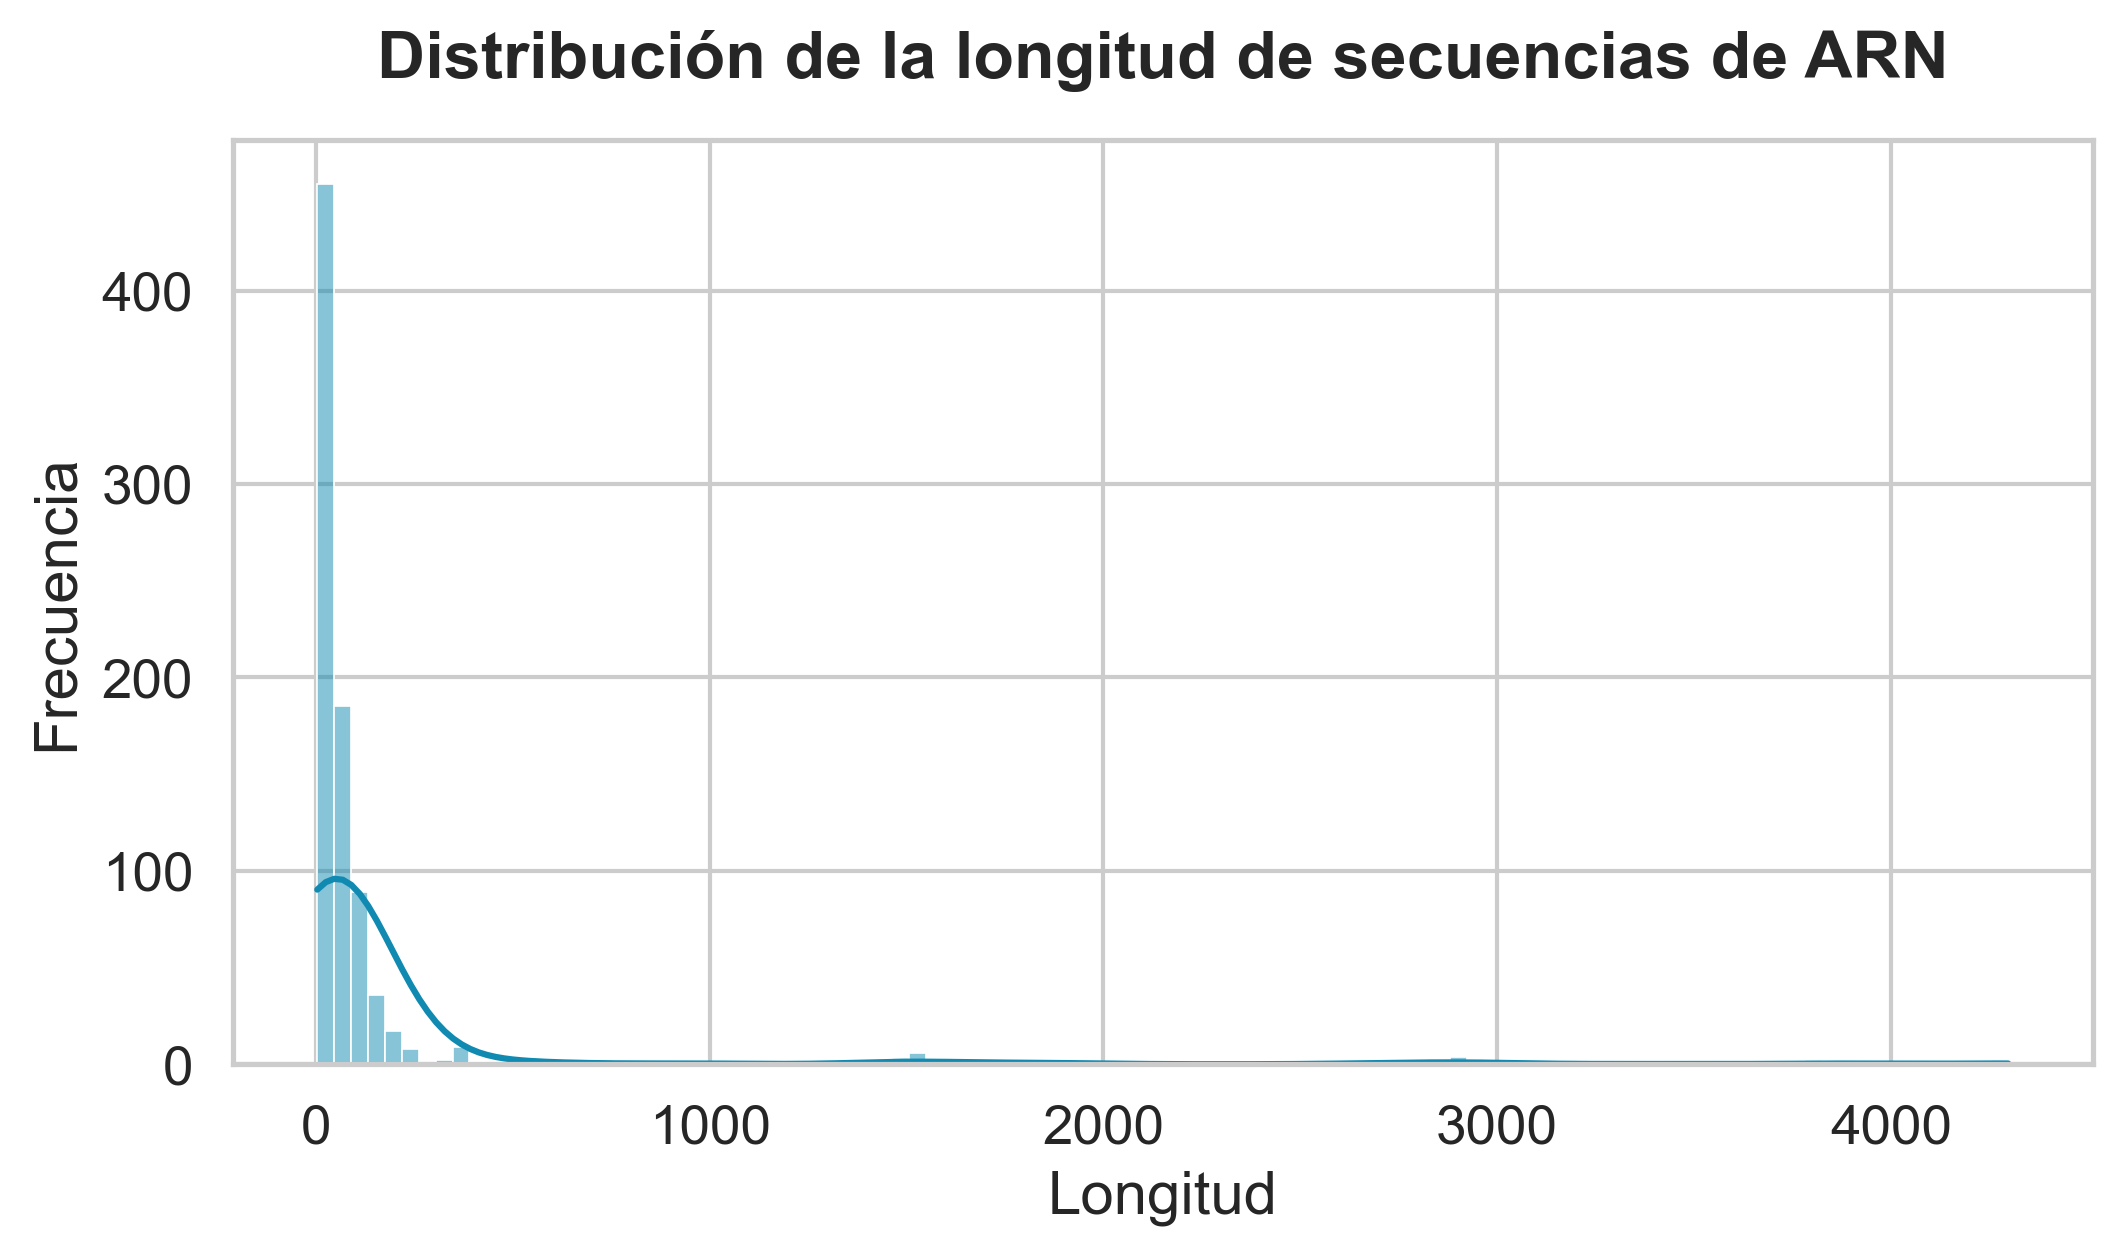

In [7]:
plt.figure(figsize=(8,4), dpi= 300)
sns.histplot(data= train_seq, 
             x= 'sequence_lenght', 
             kde= True, 
             bins= 100, 
             color='#118AB2', 
             edgecolor='white')
plt.title('Distribución de la longitud de secuencias de ARN', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

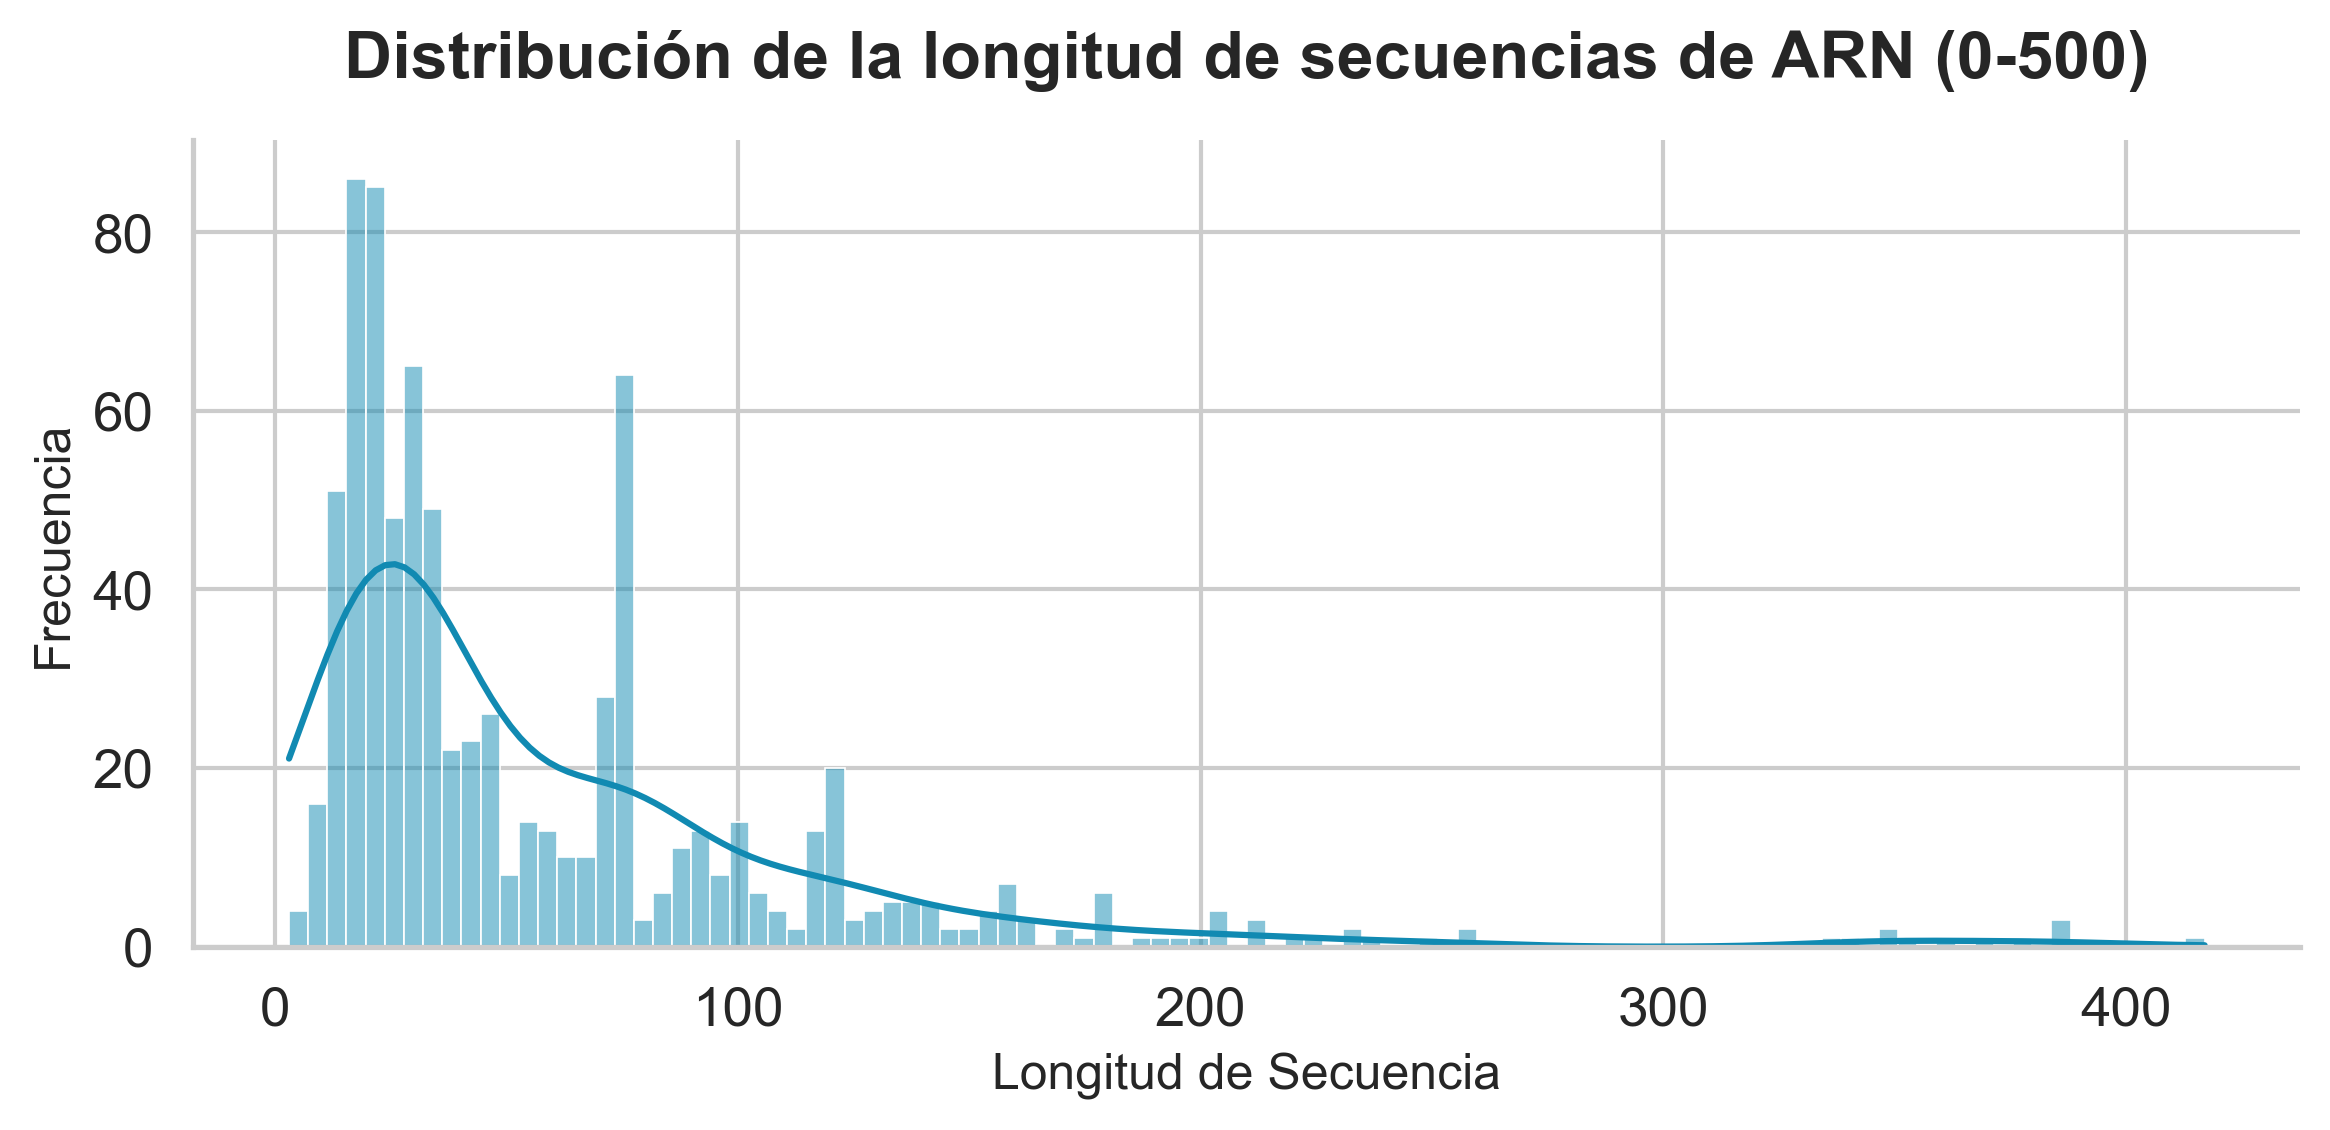

In [8]:

filtered_data = train_seq[train_seq['sequence_lenght'] <= 500]

plt.figure(figsize=(8, 4), dpi=300)
sns.histplot(
    data=filtered_data,
    x='sequence_lenght',
    kde=True,
    bins=100,
    color='#118AB2',
    edgecolor='white'
)
plt.title('Distribución de la longitud de secuencias de ARN (0-500)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Longitud de Secuencia', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

In [9]:
print(f"Secuencia más larga: {max(train_seq['sequence_lenght'])}")

Secuencia más larga: 4298


In [10]:
def nucleotide_dist(seq):
    return pd.Series({
        'A': seq.count('A')/len(seq),
        'U': seq.count('U')/len(seq),
        'G': seq.count('G')/len(seq),
        'C': seq.count('C')/len(seq),
    })

In [11]:
nucleotide_dist(train_seq['sequence'].values[67])

A    0.188525
U    0.147541
G    0.319672
C    0.344262
dtype: float64

In [12]:
train_seq['sequence'].values[67]

'UUAGGCGGCCACAGCGGUGGGGUUGCCUCCCGUACCCAUCCCGAACACGGAAGAUAAGCCCACCAGCGUUCCGGGGAGUACUGGAGUGCGCGAGCCUCUGGGAAACCCGGUUCGCCGCCACC'

In [13]:
nucleotide_freq = train_seq['sequence'].apply(nucleotide_dist)

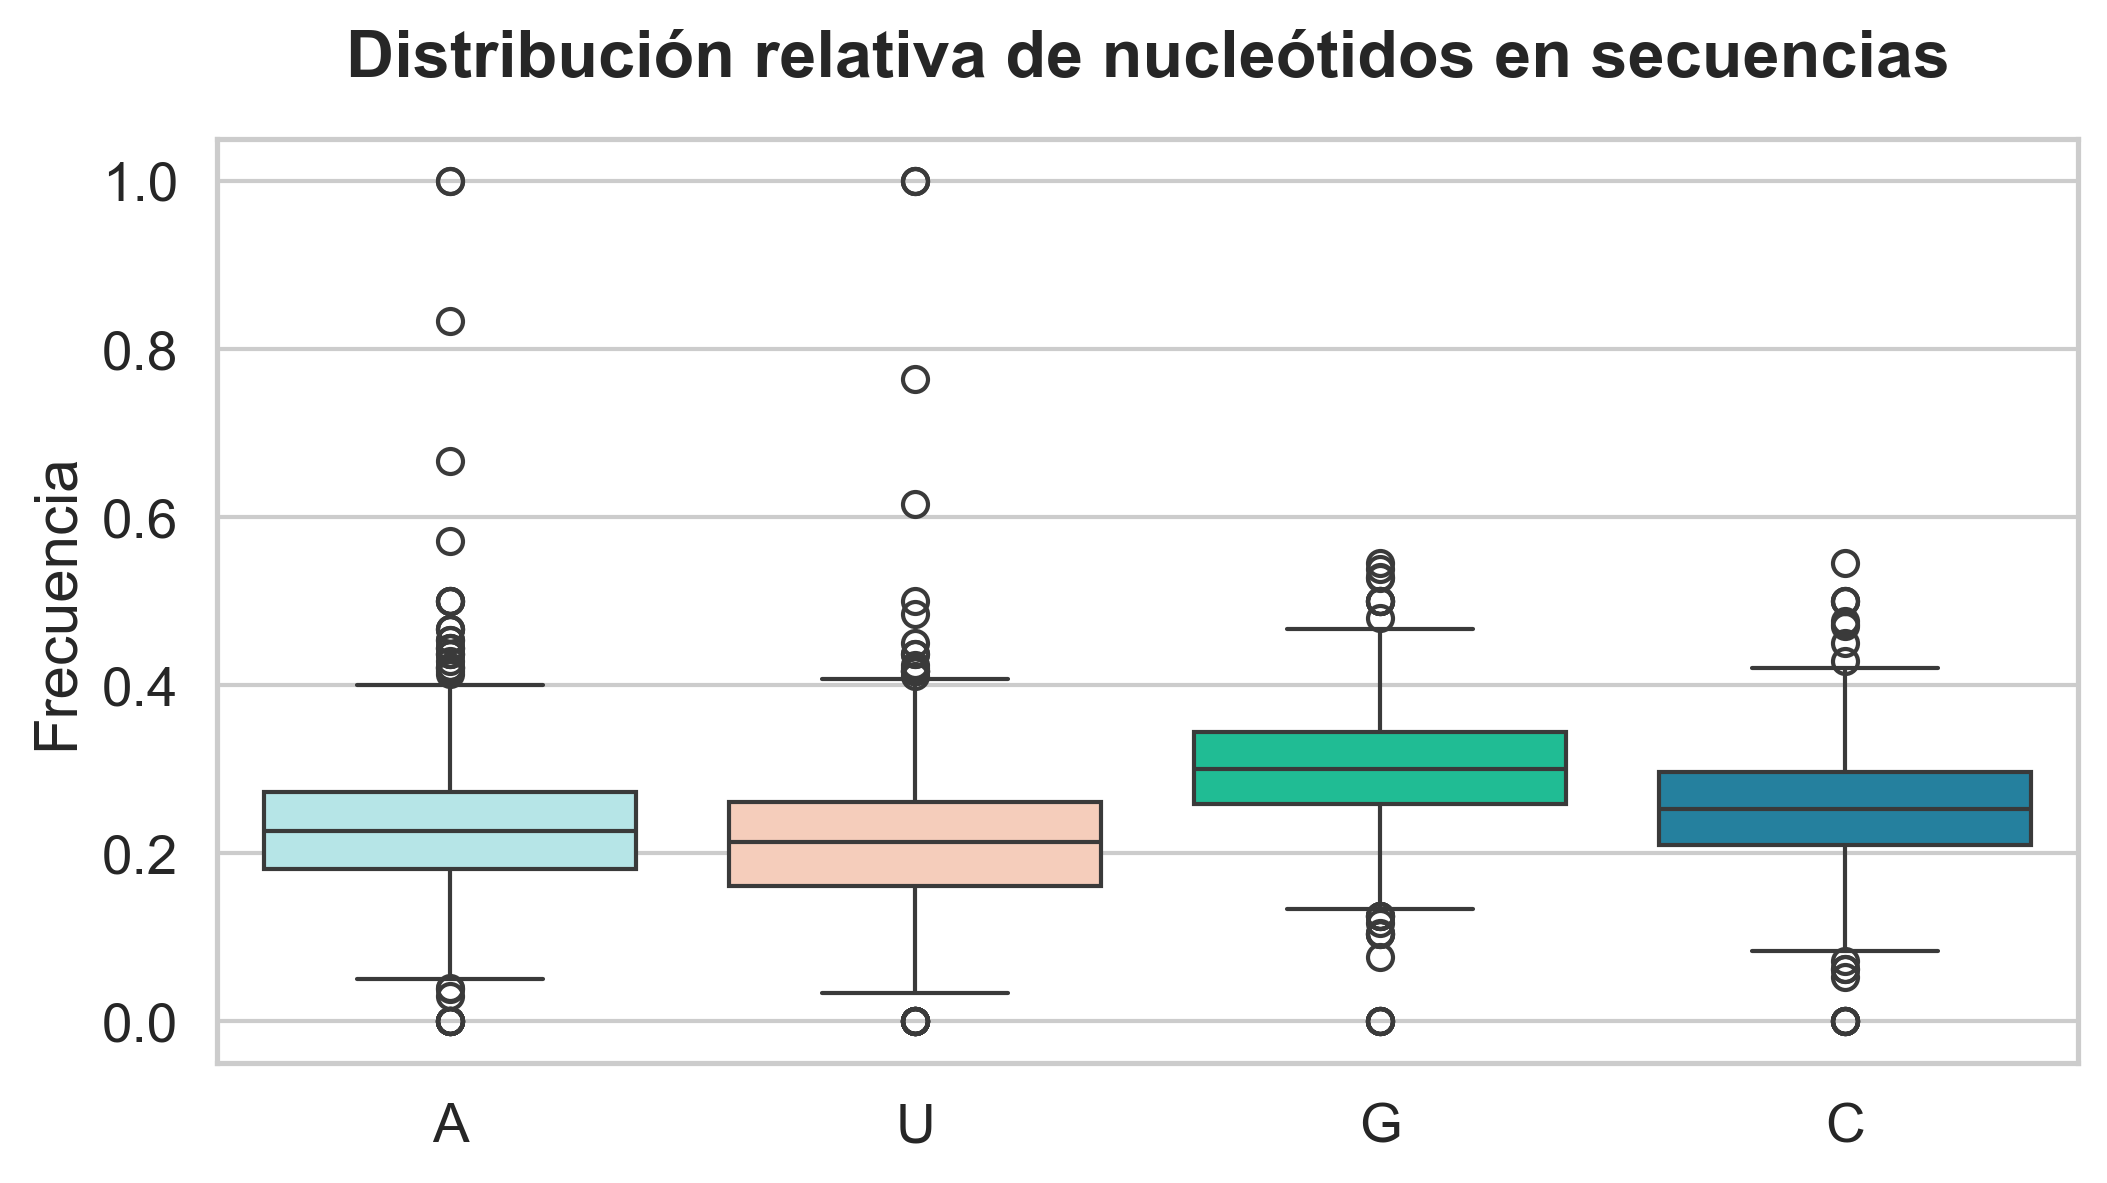

In [14]:
colors = ['#AEECEF', '#FFCAB1', '#06D6A0', '#118AB2']
plt.figure(figsize= (8,4), dpi= 300)
sns.boxplot(data= nucleotide_freq, palette= colors)
plt.title('Distribución relativa de nucleótidos en secuencias', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Frecuencia')
plt.show()

Podemos ver que hay algunos outliers que contienen únicamente Adeninas (A) y Uracilos (U). Es importante analizar estos casos para determinar si deben ser excluidos de nuestras muestras de entrenamiento. Esto permitiría reducir la longitud de la secuencia más larga, con el fin de obtener una arquitectura más estable al momento de modelar una red neuronal.

In [15]:
def max_nucleotide_freq(seq: str) -> float:
    total = len(seq)
    freqs = {
        'A': seq.count('A') / total,
        'C': seq.count('C') / total,
        'G': seq.count('G') / total,
        'U': seq.count('U') / total
    }
    return max(freqs.values())
    

In [16]:
train_seq['max_nuc_freq'] = train_seq['sequence'].apply(max_nucleotide_freq)

In [19]:
mask = train_seq['max_nuc_freq'] > 0.95
drop_sequences = train_seq[mask]
train_seq_filtrado = train_seq[~mask]

print(f"Filas dominadas por un solo nucleótido (>95%): {drop_sequences.shape[0]}")
print(f"Filas restantes: {train_seq_filtrado.shape[0]}")

Filas dominadas por un solo nucleótido (>95%): 5
Filas restantes: 839


In [20]:
print(f"Nueva Secuencia más larga: {max(train_seq_filtrado['sequence_lenght'])}")

Nueva Secuencia más larga: 4298


AAhora exploraremos los archivos FASTA, que contienen secuencias de alineación múltiple y sirven para identificar patrones evolutivos y regiones conservadas.


In [21]:
def msa_entropy_with_reference(fasta_path, original_seq):
    msa_seqs = [str(record.seq) for record in SeqIO.parse(fasta_path, 'fasta')]

    alignment = [original_seq] + msa_seqs #incluir Secuencia origianl

    # Convertir a matriz
    alignment_array = np.array([list(seq) for seq in alignment])

    # Calcular entropía por columna
    entropy_list = []
    for col in alignment_array.T:
        _, counts = np.unique(col, return_counts=True)
        probs = counts / counts.sum()
        entropy = -np.sum(probs * np.log2(probs))
        entropy_list.append(entropy)
    return entropy_list

In [25]:
file_path = '../data/MSA/17RA_A.MSA.fasta'
file_id = os.path.basename(file_path).replace('.MSA.fasta', '')

original_seq = train_seq_filtrado.loc[train_seq['target_id'] == file_id, 'sequence'].values[0]

entropy = msa_entropy_with_reference(file_path, original_seq)
entropy_df = pd.DataFrame({
    'Posición': range(len(entropy)),
    'Entropía': entropy
})

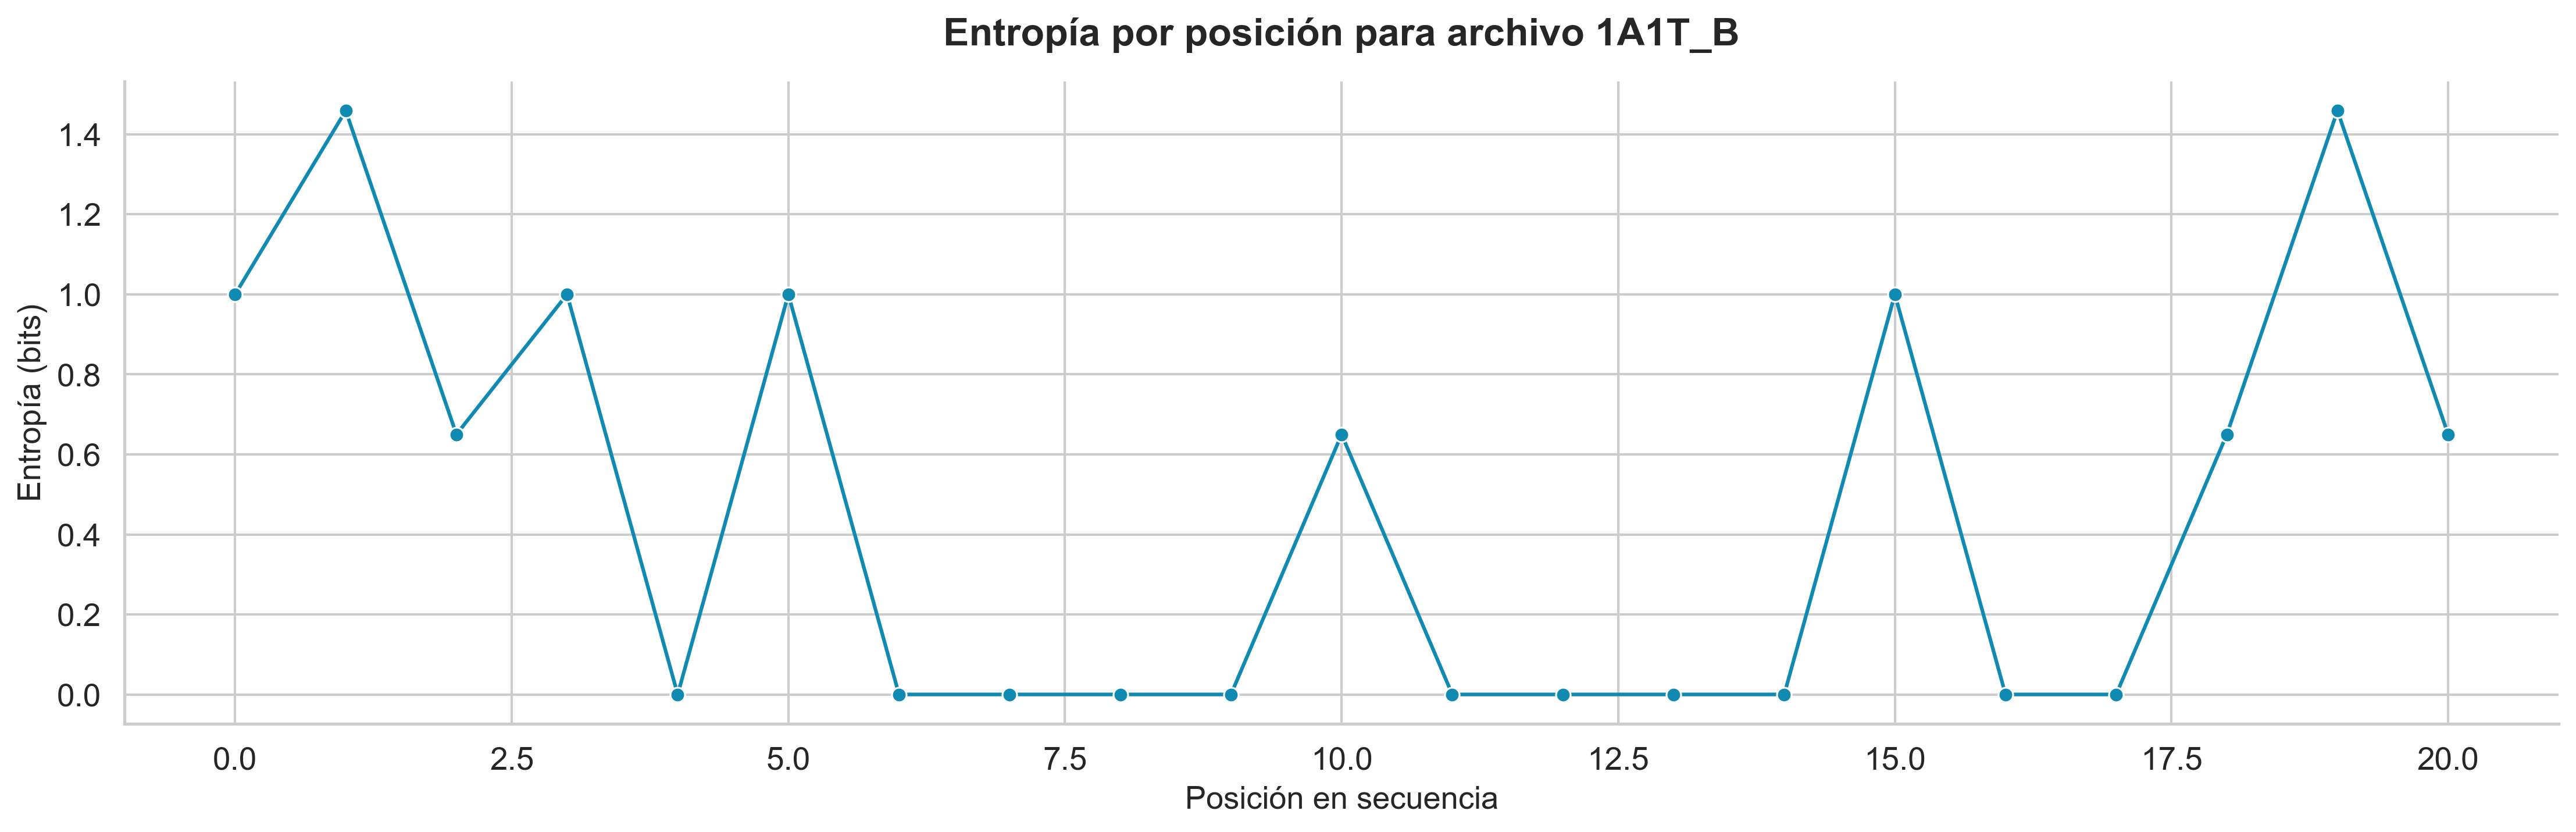

In [26]:
plt.figure(figsize=(15, 5), dpi=300)

# Gráfico de línea
sns.lineplot(data=entropy_df, x='Posición', y='Entropía', marker='o', color='#118AB2')

# Títulos y etiquetas
plt.title('Entropía por posición para archivo 1A1T_B', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Posición en secuencia', fontsize=13)
plt.ylabel('Entropía (bits)', fontsize=13)

# Rejilla y estilo adicional
plt.grid(True)
sns.despine()
plt.tight_layout()

plt.show()

In [27]:
file_path = '../data/MSA/1ATO_A.MSA.fasta'
file_id = os.path.basename(file_path).replace('.MSA.fasta', '')

original_seq = train_seq_filtrado.loc[train_seq['target_id'] == file_id, 'sequence'].values[0]

entropy = msa_entropy_with_reference(file_path, original_seq)
entropy_df = pd.DataFrame({
    'Posición': range(len(entropy)),
    'Entropía': entropy
})

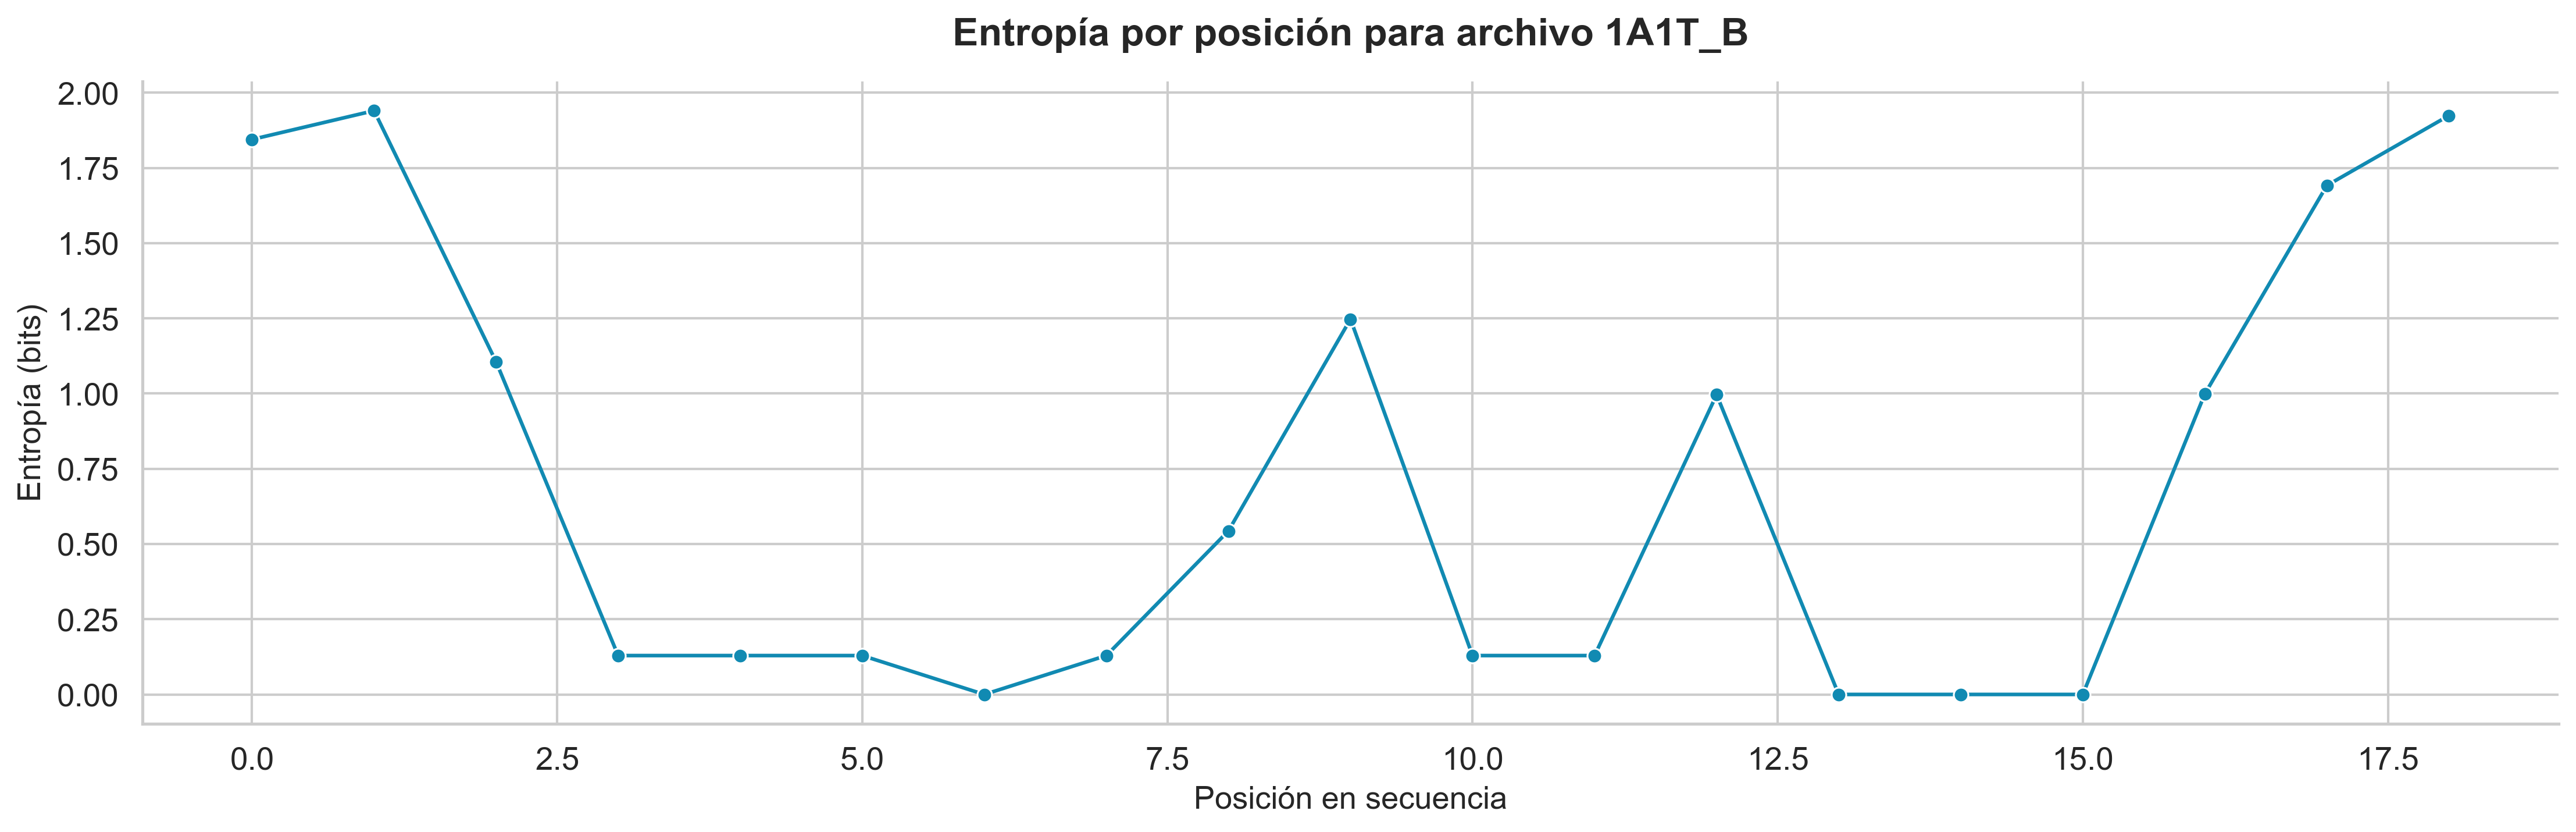

In [28]:
plt.figure(figsize=(15, 5), dpi=300)

# Gráfico de línea
sns.lineplot(data=entropy_df, x='Posición', y='Entropía', marker='o', color='#118AB2')

# Títulos y etiquetas
plt.title('Entropía por posición para archivo 1A1T_B', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Posición en secuencia', fontsize=13)
plt.ylabel('Entropía (bits)', fontsize=13)

# Rejilla y estilo adicional
plt.grid(True)
sns.despine()
plt.tight_layout()

plt.show()

La entropía mide la variabilidad que hay entre una secuencia de nucleótidos y sus MSA. A mayor entropía, significa que esa zona cambia más; una baja entropía indica que suele haber conservación de ese nucleótido. Como se observa en las gráficas, estas variaciones suelen concentrarse en zonas específicas. Por ejemplo, del nucleótido 3 al 6 hay conservación, o del 13 al 15. Por el momento guardaremos el dataframe filtrado de train como lo tenemos y crearemos un dataframe con las entropias por secuencia para utilizarlo en futuros notebooks.

### Crear dataframe con entropias de cada frecuencia para obtener mejores features 

In [36]:
msa_folder = os.path.join('..', 'data', 'MSA')
entropy_results = {}
max_len = 0

seq_dict = dict(zip(train_seq_filtrado['target_id'], train_seq_filtrado['sequence']))
for file in os.listdir(msa_folder):
    if file.endswith('.fasta'):
        file_id = file.replace('.MSA.fasta', '')
        file_path = os.path.join(msa_folder, file)

        # Obtener secuencia original correspondiente
        if file_id not in seq_dict:
            continue  # Saltar si no hay secuencia original

        original_seq = seq_dict[file_id]
        entropy_values = msa_entropy_with_reference(file_path, original_seq)
        entropy_results[file_id] = entropy_values
        max_len = max(max_len, len(entropy_values))

for key in entropy_results:
    entropy = entropy_results[key]
    if len(entropy) < max_len:
        entropy_results[key] = entropy + [np.nan] * (max_len - len(entropy))

In [37]:
entropy_df = pd.DataFrame(entropy_results)
print(entropy_df.shape)
entropy_df.head()

(4298, 839)


,4A4U_A,4V6W_BC,8DC2_B,3W1K_F,1YSH_A,2RLU_A,6WLT_A,3A2K_C,6OJ2_QW,2DU5_D,...,4V4N_B2,8H6E_4A,8EXY_R,7V59_C,1F85_A,1RY1_E,1OW9_A,2JWV_A,4V5G_BB,3WQZ_C
0,0.583584,1.722136,0.905587,1.233717,0.419571,-0.0,2.014722,0.805073,0.998486,0.922783,...,-0.0,1.622628,1.978495,2.041151,-0.0,1.191964,0.863121,1.305625,1.644360,1.077250
1,0.714653,1.585374,0.905587,0.865668,1.938841,-0.0,2.000832,1.618808,1.423995,1.340606,...,-0.0,1.039014,0.968126,2.127202,-0.0,0.655367,1.574417,1.064139,1.570834,1.756345
2,1.648826,1.863899,0.905587,1.677416,0.862807,-0.0,2.133141,1.689083,1.504349,1.649138,...,-0.0,1.325032,0.712755,2.047869,-0.0,0.135239,0.371232,1.152161,1.576972,1.797490
3,0.802224,2.121168,1.558939,1.760372,0.185488,-0.0,1.659555,1.621836,1.694412,1.937440,...,-0.0,0.904637,0.242904,2.104996,-0.0,0.427696,1.626689,0.901745,1.594358,1.726949
4,0.329846,1.893976,1.236641,1.385298,0.038807,-0.0,2.032233,1.716726,1.850838,2.043508,...,-0.0,0.862850,1.063035,1.851991,-0.0,1.203125,0.946373,1.327849,1.983545,1.885012


In [38]:
save_entropy_path = os.path.join('..', 'data', 'processed', 'entropy_data.csv')
save_train_path = os.path.join('..', 'data', 'processed', 'processed_train_seqs.csv')

In [39]:
entropy_df.to_csv(save_entropy_path)
train_seq_filtrado.to_csv(save_train_path)

### Analisis de labels

In [14]:
train_data_path = os.path.join('..', 'data', 'labeled', 'train_labeled.csv')
df_train = pd.read_csv(train_data_path)

val_data_path = os.path.join('..', 'data', 'labeled', 'val_labeled.csv')
df_val = pd.read_csv(val_data_path)

df_train = df_train[~((df_train['x_1'] == -1e18) | 
                      (df_train['y_1'] == -1e18) | 
                      (df_train['z_1'] == -1e18))]

# Si deseas aplicar lo mismo a df_val
df_val = df_val[~((df_val['x_1'] == -1e18) | 
                  (df_val['y_1'] == -1e18) | 
                  (df_val['z_1'] == -1e18))]

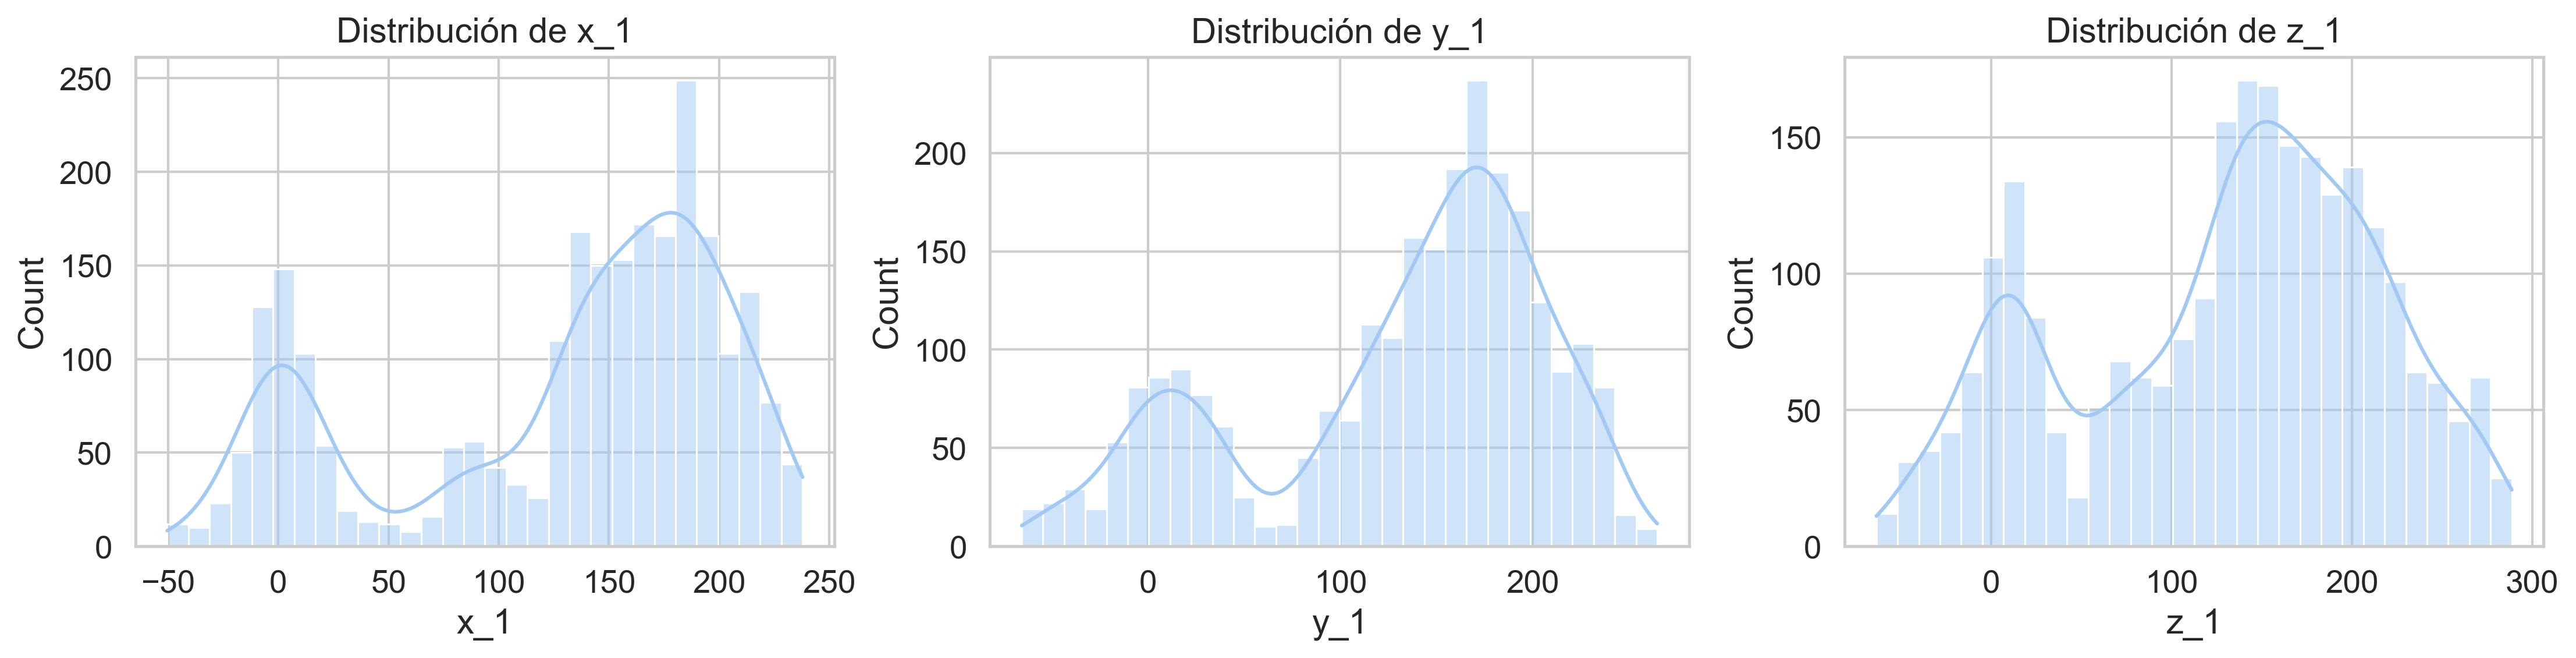

,x_1,y_1,z_1
count,2500.000000,2500.000000,2500.000000
mean,127.716758,129.601653,129.471334
std,76.850512,77.310008,84.537244
min,-50.471001,-65.489998,-63.500000
25%,80.339748,87.887999,66.973249
50%,152.987495,151.767502,144.059502
75%,185.663002,185.327003,193.357254
max,237.899994,264.690002,288.670013


In [15]:
plt.figure(figsize=(15, 4), dpi = 300)
for i, col in enumerate(['x_1', 'y_1', 'z_1']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_val[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Boxplots

df_val[['x_1', 'y_1', 'z_1']].describe()

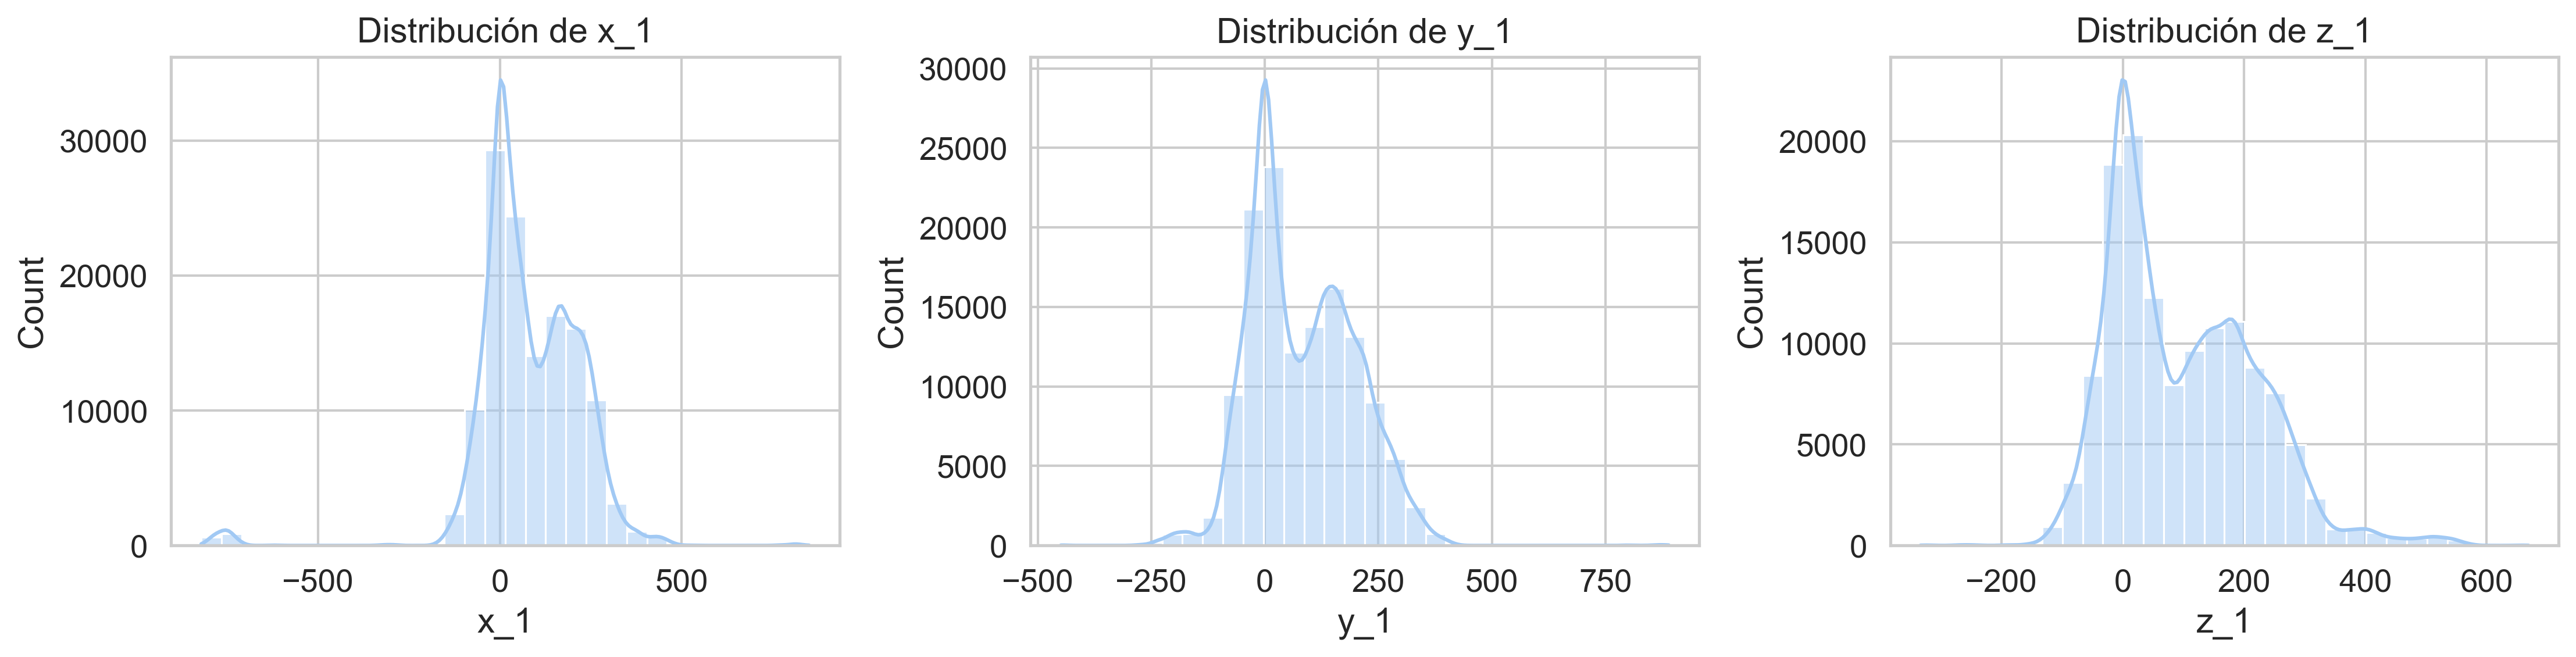

,x_1,y_1,z_1
count,130920.000000,130920.000000,130920.000000
mean,80.460428,84.034758,98.632521
std,147.436516,114.934479,119.414859
min,-821.085999,-449.414001,-333.403992
25%,-1.118750,-4.895000,2.224250
50%,62.702000,67.885502,72.980999
75%,178.831001,170.445251,184.549747
max,849.887024,889.507996,668.776978


In [16]:
plt.figure(figsize=(15, 4), dpi = 300)
for i, col in enumerate(['x_1', 'y_1', 'z_1']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Boxplots

df_train[['x_1', 'y_1', 'z_1']].describe()